### INTRODUCTION TO *AUTOENCODERS*

MAIN OBJECTIVES:
- construct a simple version of a (convolutional) autoencoder
- understand  and limitations of the model
- investigate the properties of representations of the model

The next few blocks set up the basics for training the models we are going to inspect later:

- we make sure folders in the course repo are available;
- we load the MNIST dataset and check the data looks as expected;
- we define basic training and test functionalities we will use for learning the weights of our model
- we define standard training hyperparameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/PROVA/

/content/drive/MyDrive/PROVA


In [1]:
# basic imports, load MNIST
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')


minibatch_size_train = 128
minibatch_size_test = 128


transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

trainset = torchvision.datasets.MNIST('./data/', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size_train, shuffle=True)

testset = torchvision.datasets.MNIST('./data/', transform=transforms, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size_test, shuffle=False)


100%|██████████████████████████████████████| 9.91M/9.91M [00:04<00:00, 2.03MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 251kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.27MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.91MB/s]


Handle devices; set parameters for training and for regulating model dimension.


In [2]:
#make sure we handle correctly hardware resources depending on availability, and fix seed
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
#training parameters
num_epochs = 5
learning_rate = 1e-3

#model parameters
latent_dims = 10
capacity = 64

Exercise 1. The autoencoder class.

We will construct a convolutional encoder and decoder. In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

- Given the symmetry in the definition of the autoencoder, deduce the correct dimensions for the layers of the encoder starting from the given decoder. "Hint": use the function summary as in previous notebook verify that the dimensions mathc.

In [4]:
class Encoder(nn.Module):
    '''
    Your code here
    '''
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        '''
        Complete the following lines with appropriate 2d convolutions
        '''
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(in_features= c*2*7*7, out_features= latent_dims)


    def forward(self, x):
        #print('-------------------- Inside Encoder------------------')
        #print('original shape : {}'.format(x.shape) )
        x = F.relu(self.conv1(x))
        #print('after 1st conv layer : {}'.format(x.shape) )
        x = F.relu(self.conv2(x))
        #print('after 2nd conv layer : {}'.format(x.shape) )
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        #print('after flattening : {}'.format(x.shape) )
        x = self.fc(x)
        #print('after fc : {}'.format(x.shape) )
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        #print('-------------------- Inside Decoder------------------')
        #print('before fc : {}'.format(x.shape) )
        x = self.fc(x)
        #print('after fc : {}'.format(x.shape) )
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        #print('after unflattening : {}'.format(x.shape) )
        x = F.relu(self.conv2(x))
        #print('after first convtranspose : {}'.format(x.shape) )
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        #print('after second convtranspose : {}'.format(x.shape) )
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

In [5]:
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

summary(autoencoder,(1,28,28,))

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Total number of parameters: %d' % num_params)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
            Conv2d-2            [-1, 128, 7, 7]         131,200
            Linear-3                   [-1, 10]          62,730
           Encoder-4                   [-1, 10]               0
            Linear-5                 [-1, 6272]          68,992
   ConvTranspose2d-6           [-1, 64, 14, 14]         131,136
   ConvTranspose2d-7            [-1, 1, 28, 28]           1,025
           Decoder-8            [-1, 1, 28, 28]               0
Total params: 396,171
Trainable params: 396,171
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 1.51
Estimated Total Size (MB): 1.81
----------------------------------------------------------------
Total number of parameters: 396171


The following block is a very simple version of training strategy.

NOTE the choice of MSE loss function for computing the reconstruction error as described in class.

REMEMBER to save (NOT only in Colab) the weights after 50 epochs!

In [6]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in trainloader:

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

torch.save(autoencoder.state_dict(),"auto_cnn.pt")

Training ...
Epoch [1 / 5] average reconstruction error: 0.472733
Epoch [2 / 5] average reconstruction error: 0.417191
Epoch [3 / 5] average reconstruction error: 0.408458
Epoch [4 / 5] average reconstruction error: 0.403461
Epoch [5 / 5] average reconstruction error: 0.400243


We monitor the learning procedure by plotting the training loss.

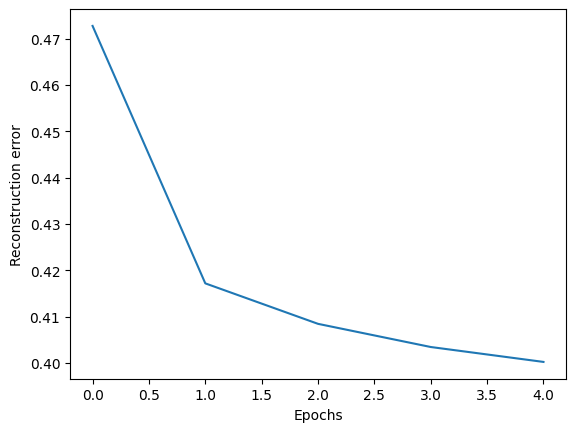

In [7]:
import matplotlib.pyplot as plt
#plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

And verifying that the test loss of the final model is compatible with the training one.

In [8]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in testloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.405324


Exercise 2: visualize reconstructions.
- recall the basic plot functionality for a sample of MNIST digits in a batch of the test set
- evaluate qualitatively the model plotting the corresponding reconstructed images

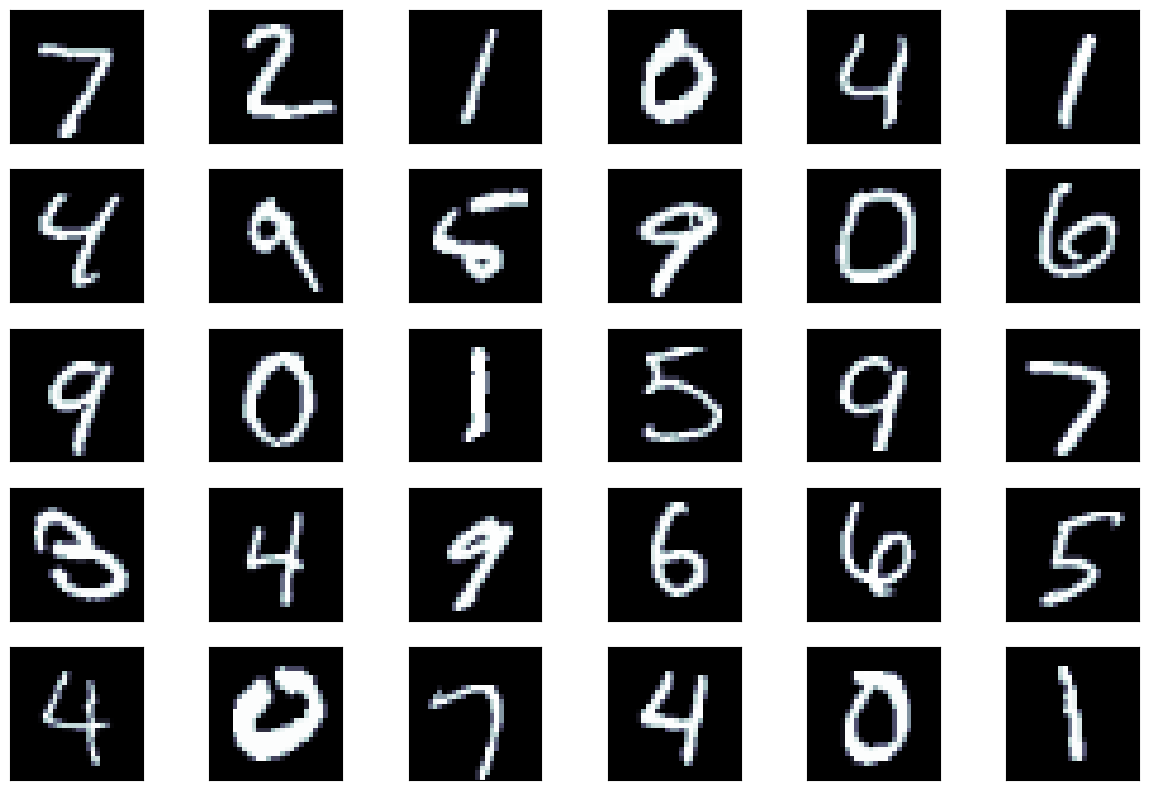

In [9]:
#we plot the first 30 digits in the testloader batch
inputs,labels = next(iter(testloader))

fig=plt.figure(figsize=(15,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(np.squeeze(inputs[i]),cmap='bone')
    plt.xticks([])
    plt.yticks([])

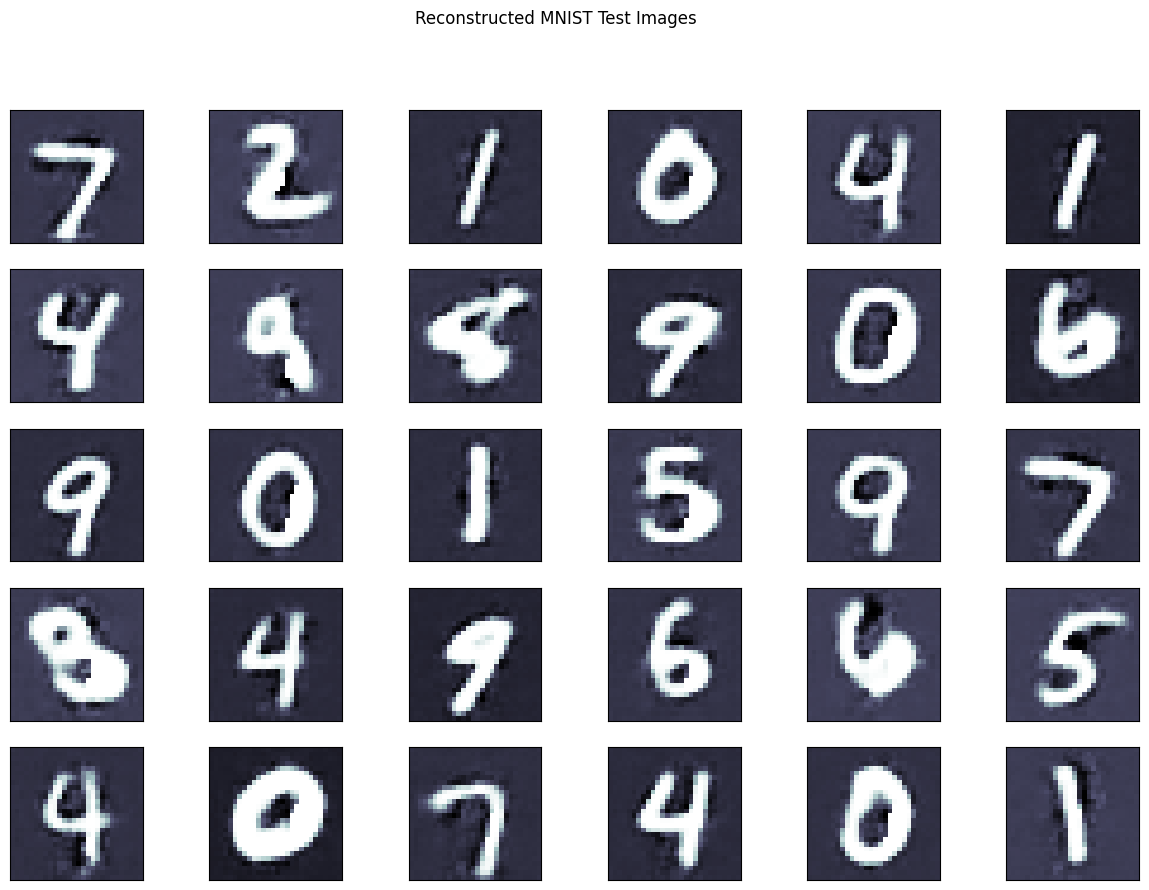

In [10]:
#compare with the reconstruction by performing inference
'''
Your code here
'''
inputs = inputs.to(device)
with torch.no_grad():
    reconstructions = autoencoder(inputs)
reconstructions = reconstructions.cpu()

# Plot the corresponding 30 reconstructed images.
fig = plt.figure(figsize=(15,10))
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.imshow(np.squeeze(reconstructions[i]), cmap='bone')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Reconstructed MNIST Test Images')
plt.show()

Inspect the ability of the autoencoder to interpolate between different digits moving along a line in the latent space. Explore how different interpolation give drastically different results by changing digit type.

In [11]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)
        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2
        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

    return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in testloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

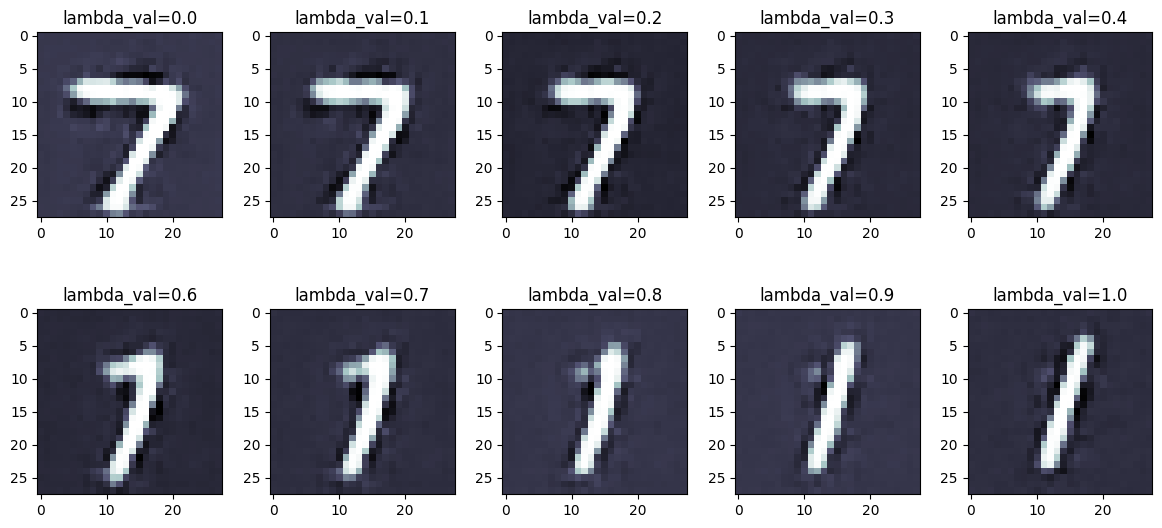

In [12]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

digit1 = 1
digit2 = 7
for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[digit1][0], digits[digit2][0])
    axs[ind].imshow(inter_image[0,0,:,:].cpu().detach().numpy(), cmap='bone')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show()

Exercise 3. Can an autoencoder be considered an image generator?

- Consider a batch of images in the test set. Compute the latent codes by means of the encoder.
- Compute the mean $\mu$ and variance $\Sigma$ of the latent codes obtained from the encoding.
- Sample 128 elements in the latent space sampling from $\mathcal{N}(\mu,\Sigma)$. Compute the images corresponding to the codes by means of the decoder.
- Plot the result similarly as above.


You should observe that even if we are in the same region of the latent space as the encoded data, but even so, generating new digits is hit-or-miss: many latent vectors decode to something that does not look like a digit.

This means that the manifold of latent vectors that decode to valid digits is sparse in latent space. With higher-dimensional latent spaces, the manifold gets sparser.

In [13]:
autoencoder.eval()
#Probably you will need to disable gradient calculation for doing this smoothly
'''
with torch.no_grad():
  Your code here
'''
autoencoder.eval()
with torch.no_grad():
    # Collect latent codes for the entire test set.
    latent_codes = []
    for image_batch, _ in testloader:
        image_batch = image_batch.to(device)
        latent = autoencoder.encoder(image_batch)
        latent_codes.append(latent)
    latent_codes = torch.cat(latent_codes, dim=0)

    # Compute mean (mu) and standard deviation (sigma) of the latent codes.
    mu = latent_codes.mean(dim=0)
    sigma = latent_codes.std(dim=0)

    # Sample 128 latent vectors from N(mu, sigma^2)
    sampled_latents = torch.randn(128, latent_dims).to(device) * sigma + mu

    # Generate images from the sampled latent codes.
    generated_images = autoencoder.decoder(sampled_latents)
    generated_images = generated_images.cpu()

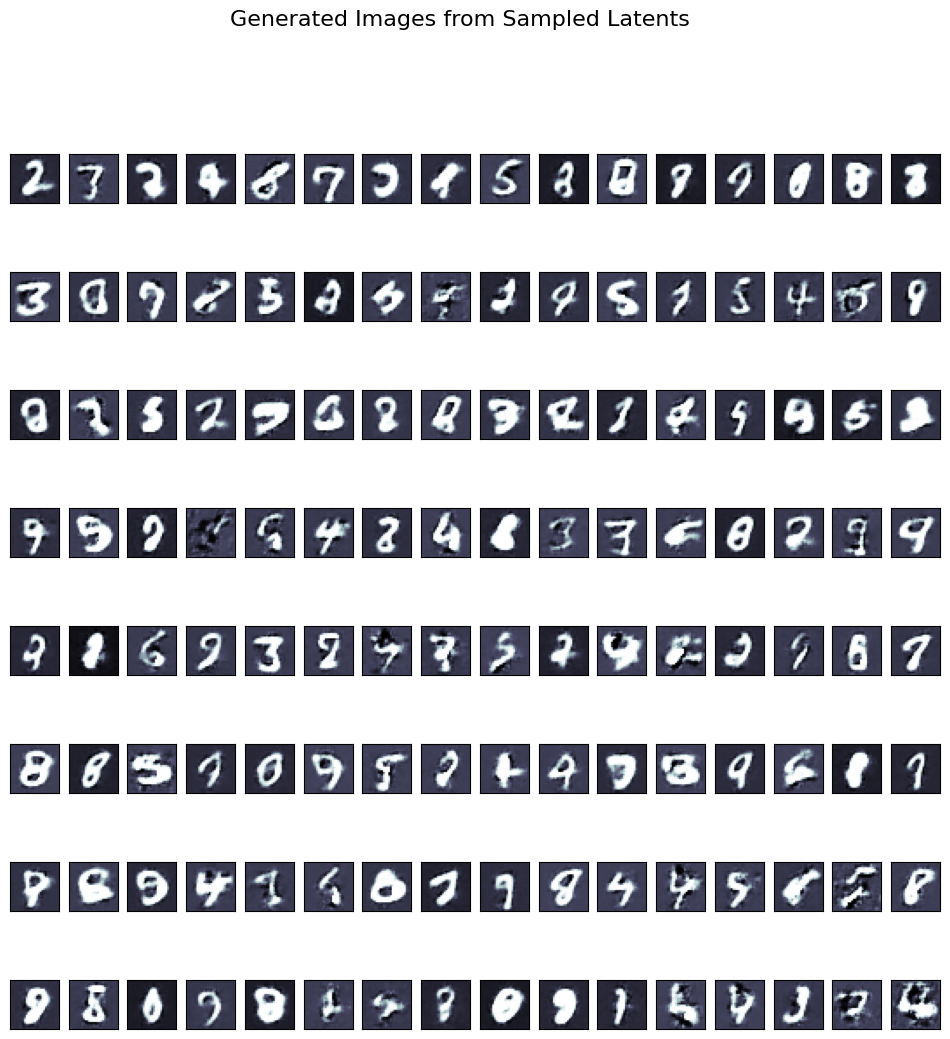

In [14]:
# Plot the 128 generated images.
fig = plt.figure(figsize=(12, 12))
for i in range(128):
    plt.subplot(8, 16, i+1)  # 8 rows x 16 columns => 128 images
    plt.imshow(generated_images[i, 0, :, :].detach().numpy(), cmap='bone')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Generated Images from Sampled Latents', fontsize=16)
plt.show()

Exercise:

- Monitor the hidden representations of the autoencoder following the analysis of notebook 08-representations.ipynb (i.e. visualisation of convolution outputs, TSNE projections, intrinsic dimension)

In [15]:
# Extract latent representations for the test set.
with torch.no_grad():
    latent_features = []
    labels_list = []
    for images, labels in testloader:
        images = images.to(device)
        latent = autoencoder.encoder(images)
        latent_features.append(latent.cpu().numpy())
        labels_list.append(labels.numpy())
    latent_features = np.concatenate(latent_features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)

In [16]:
# Import TSNE from scikit-learn and apply to the latent features.
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_features)

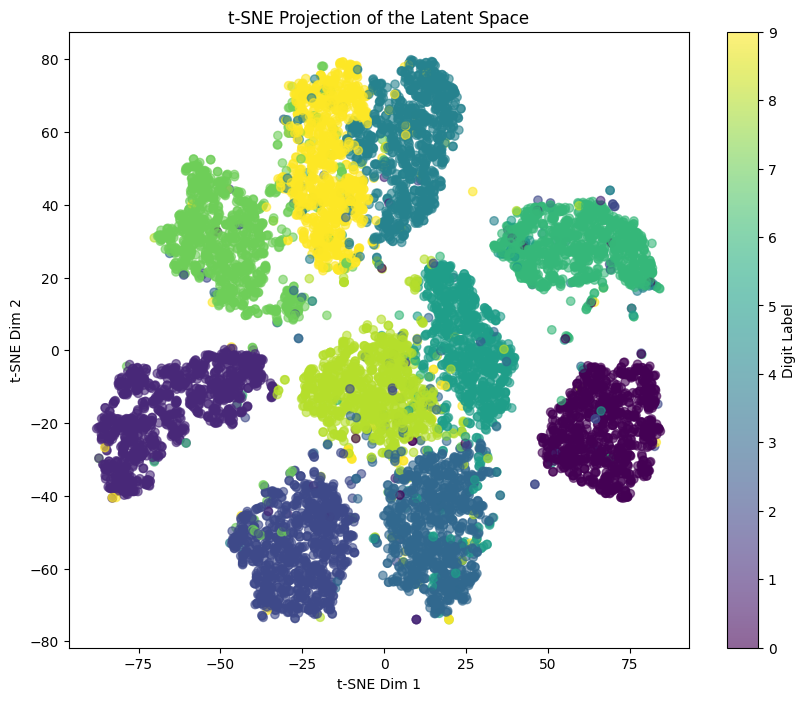

In [17]:
# Plot the t-SNE projection.
plt.figure(figsize=(10,8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_list, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Digit Label')
plt.title("t-SNE Projection of the Latent Space")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()